# Quantifying the folding states in global HDX-MS

The folding states during refolding were quantified using one charged (24+), multimodal m/z peak. The unfolded and folded state were fitted using the m/z peak of the fully denaturated control and last timepoint. The intermediate state was fitted with a Lorentzian curve where the predicted mean and width could be adjusted for an optimal fit. 

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import peakutils
from smitting.fitting import LMFit
from smitting.distributions import Lorentzian, Gaussian
from symfit.core.minimizers import *

In [52]:
# symfit branch matrix_bounds is required
# + line 141 fit_results.py add TypeError (depending on numpy version)
import symfit

In [53]:
#dataset of one peak (24+ charged) of the controls
controls = np.genfromtxt('global_PpiB_4C_controls.txt').T
controls.shape

(11, 1691)

In [54]:
c_data = {
    'ND': np.stack([controls[0], controls[2]]), #Non-deuterated control (without Deuterium labeling)
    'Native': np.stack([controls[3], controls[5]]), #The Natively purified protein (min D-uptake)
    'FD': np.stack([controls[7], controls[9]]) #The Fully Denatured or Fully Deuterated control (max D-uptake)
}


for k, v in c_data.items():
    x, y = v
    
    #Calculate and subtract baseline
    bl = peakutils.baseline(y, 1)
    y_corr = y-bl
    
    #Normalize to 1
    y_corr /= np.trapz(y_corr, x)
    
    c_data[k] = np.stack([x, y_corr])

In [55]:
data_table = np.genfromtxt('global_PpiB_4C_data.txt').T
data_table.shape

(39, 1691)

In [56]:
labels = np.array(['1h', '30m', '20m', '15m', '10m', '5m', '1m', '40s', '20s', 't0'])
time = np.array([60, 30, 20, 15, 10, 5, 1, 0.67, 0.33, 0])

In [57]:
#Put data into an array and remove background with linear equation
data_raw = [np.stack([data_table[0], data_table[2]/100])] + [np.stack([data_table[(4*i)-1], data_table[(4*i)+1]/100]) for i in np.arange(9) + 1]

data_out = []
for d in data_raw:
    x, y = d
    bl = peakutils.baseline(y, 1)
    
    #Calculate and subtract baseline
    y_corr = y-bl
    y_corr /= np.trapz(y_corr, x)
    
    #Normalize to 1
    data_out.append([x, y_corr])
    
f_data = np.array(data_out)
f_data.shape

(10, 2, 1691)

In [58]:
# one set of m/z values is selected and the native and fully deuterated control is selected
global_x = c_data['Native'][0]
native = c_data['Native'][1]
FD = np.interp(global_x, *c_data['FD'])

In [59]:
data_arr = np.stack([np.interp(global_x, *d) for d in f_data])
data_arr.shape

(10, 1691)

In [60]:
# The dataset is fitted with an FD, native and intermediate state
pip = LMFit(x=x, y=data_arr.T)

bases = {
    'FD': FD,
    'native': native,
    'int1': Lorentzian,
}

In [61]:
pip.make_model(bases)

In [62]:
#Definition of the Lorentzian curve parameter for the intermediate with a mean (mu) and width (gamma) 
pip.parameters

{'A': A, 'mu_x_2': mu_x_2, 'gamma_2': gamma_2}

In [64]:
#An interval is selected for both parameters
pip.set_par('mu_x_2', min=800, max=815, value=806)
pip.set_par('gamma_2', min=0.2, max=2.8, value=0.48, fixed=False)
pip.make_fit(minimizer=MINPACK)

In [65]:
# Resulting parameters of the Lorentzian curve and fitting efficiency compared to the data
pip.execute()
print(pip.res)

Scalar Parameters:
Parameter | Value       | Standard Deviation
gamma_2     1.390844e+00  None
mu_x_2      8.058542e+02  None

Tensor Parameters:
Parameter | Shape     | Flattened preview 
A           (3, 10)     [9.44e-12 4.84e-03 3.33e-03 ... 7.35e-01 7.84e-01 1.00e-02]

Status message         Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Number of iterations   22
Objective              <symfit.core.objectives.VectorLeastSquares object at 0x0000024B9810E6D8>
Minimizer              <symfit.core.minimizers.MINPACK object at 0x0000024B9810E5F8>
Linear Solver          <symfit.core.linear_solvers.LstSqBounds object at 0x0000024B9810EF60>

Goodness of fit qualifiers:
chi_squared            0.9058402711604964
objective_value        [5.29461199e-05 7.31609684e-05 4.43888064e-04 ... 1.57921453e-03
 2.41460018e-03 1.05811970e-03]
r_squared              0.9925449631049706


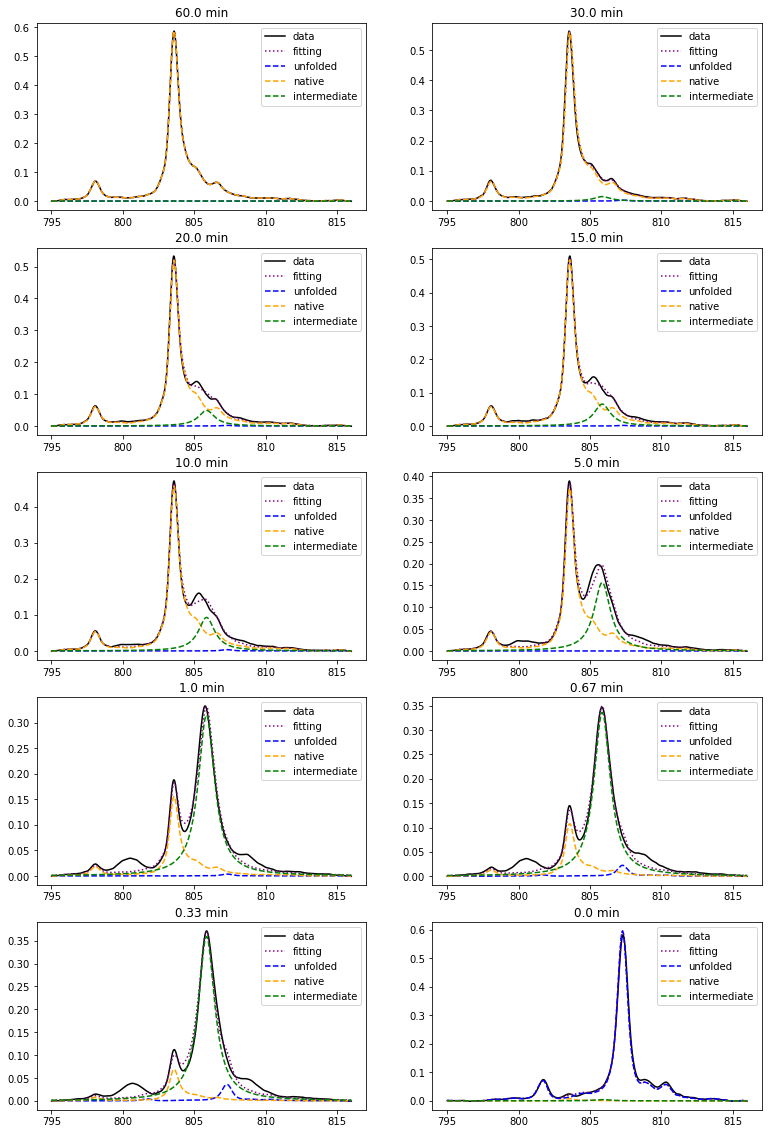

In [102]:
# Plotting of the fitting data with the different folding states on the refolding timepoints
ans = pip.ans
Y = pip.ans.Y
A = pip.res.params['A']

fig, axes = plt.subplots(5, 2, figsize=(13, 20))
for i, ax in enumerate(axes.flatten()):
    a_s = A.T[i]
    ax.plot(x, data_arr[i], color='k', label ='data')
    ax.plot(x, Y.T[i], color='purple', label='fitting', linestyle='dotted')
    ax.plot(x, a_s[0]*FD, color='b', linestyle='--', label = 'unfolded')
    ax.plot(x, a_s[1]*native, color='orange', linestyle='--', label='native')
    ax.plot(x, a_s[2]*ans.int1, color='green', linestyle='--', label='intermediate')
    #ax.plot(x, a_s[3]*ans.int2, color='k', linestyle='--')
    ax.set_title (str(time[i]) + ' min')

    ax.legend()
plt.show()

In [103]:
# check if the population fractions at each timepoint sum to one and adjust
sum = A.sum(axis=0)
sum

array([0.9999706 , 0.98999174, 0.99673924, 0.99594583, 0.98789717,
       0.97700041, 0.95945812, 0.95449455, 0.9593401 , 0.97185193])

Text(0, 0.5, 'Population fraction')

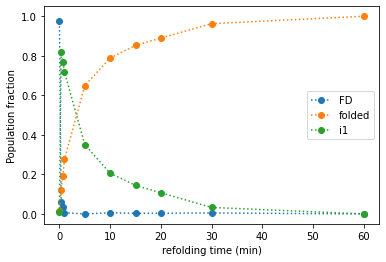

In [69]:
plt.figure()
labels = ['FD', 'folded', 'i1']
for i, a in enumerate(A):
    plt.plot(time, a/sum, label=labels[i], marker='o', linestyle=':')
plt.legend()
plt.xlabel('refolding time (min)')
plt.ylabel('Population fraction')

In [106]:
np.savetxt('global_PpiB_4C_Fitting_curve', A)